# Homework_6

## Imports & Downloads

In [ ]:
!pip install shap
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

import shap 

from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from hyperopt.fmin import fmin
from hyperopt import hp, tpe
import xgboost as xgb
import lightgbm as lgb


from google_drive_downloader import GoogleDriveDownloader as gdd

In [ ]:
gdd.download_file_from_google_drive(file_id='1xRbsTu_NIrGr2-6qk-_-dm4Mrdbx25oA',\
                                    dest_path='/data/id_map.parquet')
url = pd.read_parquet('/data/id_map.parquet')

# выделим регион в отдельный столбик
url['region'] = [x.split('.')[-1] for x in url.webpage]

# закодируем его
le = preprocessing.LabelEncoder()
url['region1'] = le.fit_transform(url['region'])

# выведем на печать
url.head(3)

,id,webpage,region,region1
0,326127,www.abmecatronique.com,com,104
1,182113,groups.live.com,com,104
2,551820,majeureliguefootball.wordpress.com,com,104


In [ ]:
gdd.download_file_from_google_drive(file_id='1ZECXtMAYo6fR8HY4eCKw9rLYzcKsgGC2',\
                                    dest_path='/data/train.csv')
train = pd.read_csv('/data/train.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

gdd.download_file_from_google_drive(file_id='12vPIGNYEO3y6UrtwoW8hVjY3z5uxV709',\
                                    dest_path='/data/test.csv')
test = pd.read_csv('/data/test.csv', index_col=0, parse_dates=[f'time{i+1}' for i in range(10)])

# создадим столбец target в test и заполним его -1.
test['target'] = -1

In [ ]:
# склеим train и test, чтобы дважды не проделывать одну и ту же работы по генерации фичей
full = pd.concat([train,test], axis=0)

Возьмем за основу фичи, предложенные в Example Notebook.

Также добавим в них свои: время, прошедшее между соседними страницами.

In [ ]:
def preproc(df):
    return (
        df.assign(
            # difference between 10th page and 1st in seconds
            first_last_diff=lambda x: (x.time10 - x.time1).dt.seconds.fillna(0),

            # difference between 2th page and 1st in seconds = time on the 1st page
            first_diff = lambda x: (x.time2 - x.time1).dt.seconds.fillna(0),

            # time on the 2 page
            second_diff=lambda x: (x.time3 - x.time2).dt.seconds.fillna(0),

            # time on the 3 page
            third_diff=lambda x: (x.time4 - x.time3).dt.seconds.fillna(0),

            # time on the 4 page
            fourth_diff=lambda x: (x.time5 - x.time4).dt.seconds.fillna(0),

            # time on the 5 page
            fifth_diff=lambda x: (x.time6 - x.time5).dt.seconds.fillna(0),

            # time on the 6 page
            sixth_diff=lambda x: (x.time7 - x.time6).dt.seconds.fillna(0),

            # time on the 7 page
            seventh_diff=lambda x: (x.time8 - x.time7).dt.seconds.fillna(0),

            # time on the 8 page
            eighth_diff=lambda x: (x.time9 - x.time8).dt.seconds.fillna(0),

            # time on the 9 page
            nineth_diff=lambda x: (x.time10 - x.time9).dt.seconds.fillna(0),

            # number of missing pages (from 10 max)
            nans_count=lambda x: x.isna().sum(axis=1).div(2),

            # number of unique pages in session
            n_unique_pages=lambda x: 
                x.filter(like='webpage').apply(lambda row: row.nunique(), axis=1) / (10 - x.nans_count),

            # avg hour of day in a session
            avg_hour=lambda x: x.filter(like='time').apply(lambda x: x.dt.hour).mean(axis=1),

            # avg day of week in a session
            avg_day=lambda x: x.filter(like='time').apply(lambda x: x.dt.dayofweek).mean(axis=1),
        )
        # drop time columns
        .drop(columns=[f'time{i+1}' for i in range(10)])
        # fill missing pages with zeros
        .fillna(0.)
    )

In [ ]:
full = preproc(full)

In [ ]:
full.head(3)

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,target,first_last_diff,first_diff,second_diff,third_diff,fourth_diff,fifth_diff,sixth_diff,seventh_diff,eighth_diff,nineth_diff,nans_count,n_unique_pages,avg_hour,avg_day
session_id,,,,,,,,,,,,,,,,,,,,,,,,,
0,9486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,5.0,2.0
1,11722,12385.0,50163.0,12385.0,12398.0,50150.0,50163.0,50150.0,19860.0,19886.0,0,26.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,0.0,0.7,7.0,4.0
2,192149,659.0,192136.0,192149.0,633.0,659.0,192136.0,192136.0,192136.0,192136.0,0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.4,12.0,6.0


В файлу url представлен список всех посещенных вебстраниц. "Откусим" от каждого из них имя домена.



In [ ]:
keys = list(url.id)
values = list(url.region1)
dictionary = dict(zip(keys, values))
dictionary[0] = 0

In [ ]:
full['reg1'] = [dictionary.get(x) for x in full.webpage1]
full['reg2'] = [dictionary.get(x) for x in full.webpage2]
full['reg3'] = [dictionary.get(x) for x in full.webpage3]
full['reg4'] = [dictionary.get(x) for x in full.webpage4]
full['reg5'] = [dictionary.get(x) for x in full.webpage5]
full['reg6'] = [dictionary.get(x) for x in full.webpage6]
full['reg7'] = [dictionary.get(x) for x in full.webpage7]
full['reg8'] = [dictionary.get(x) for x in full.webpage8]
full['reg9'] = [dictionary.get(x) for x in full.webpage9]
full['reg10'] = [dictionary.get(x) for x in full.webpage10]

У нас есть категориальные фичи (индексы страниц), у которых формат float64.Приведем их к виду str (иначе алгоритм будет их считать числовыми переменными, которые можно упорядочить).

In [ ]:
full['webpage1'] = [str(int(x)) for x in full.webpage1]
full['webpage2'] = [str(int(x)) for x in full.webpage2]
full['webpage3'] = [str(int(x)) for x in full.webpage3]
full['webpage4'] = [str(int(x)) for x in full.webpage4]
full['webpage5'] = [str(int(x)) for x in full.webpage5]
full['webpage6'] = [str(int(x)) for x in full.webpage6]
full['webpage7'] = [str(int(x)) for x in full.webpage7]
full['webpage8'] = [str(int(x)) for x in full.webpage8]
full['webpage9'] = [str(int(x)) for x in full.webpage9]
full['webpage10'] = [str(int(x)) for x in full.webpage10]

Сбросим индексы, а также столбец с ними.

In [ ]:
full = full.reset_index()
full = full.drop(columns = ['session_id'])
full

,webpage1,webpage2,webpage3,webpage4,webpage5,webpage6,webpage7,webpage8,webpage9,webpage10,target,first_last_diff,first_diff,second_diff,third_diff,fourth_diff,fifth_diff,sixth_diff,seventh_diff,eighth_diff,nineth_diff,nans_count,n_unique_pages,avg_hour,avg_day,reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10
0,9486,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.000000,5.0,2.0,104,0,0,0,0,0,0,0,0,0
1,11722,12385,50163,12385,12398,50150,50163,50150,19860,19886,0,26.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,0.0,0.700000,7.0,4.0,104,104,104,104,104,104,104,104,51,66
2,192149,659,192136,192149,633,659,192136,192136,192136,192136,0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,0.400000,12.0,6.0,104,104,104,104,104,104,104,104,104,104
3,10591,451,77580,227821,633,425,10591,227834,227834,227834,0,102.0,0.0,0.0,0.0,30.0,69.0,0.0,1.0,1.0,1.0,0.0,0.700000,12.0,2.0,104,104,104,104,104,120,104,104,104,104
4,438,425,529,65685,187638,451,425,65685,187625,187625,0,6.0,0.0,2.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.700000,6.0,3.0,104,120,104,176,120,104,120,176,176,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253302,659,111380,13659,10708,7562,13659,10214,10708,2323,2323,-1,108.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,103.0,1.0,0.0,0.700000,10.0,2.0,104,196,104,104,104,104,104,104,104,104
253303,1153,1127,1153,1127,867,880,867,1140,1127,1192,-1,14.0,0.0,2.0,3.0,6.0,0.0,1.0,2.0,0.0,0.0,0.0,0.600000,7.0,6.0,104,104,104,104,104,104,104,104,104,104
253304,13659,10708,13659,10214,13659,10214,13659,10214,13659,0,-1,0.0,575.0,160.0,80.0,160.0,463.0,2.0,239.0,1.0,0.0,1.0,0.333333,10.0,1.0,104,104,104,104,104,104,104,104,104,0
253305,309513,15375,191,191,256,256,191,334538,334551,204,-1,26.0,2.0,1.0,2.0,1.0,12.0,2.0,2.0,1.0,3.0,0.0,0.700000,9.0,0.0,176,104,104,104,176,176,104,120,104,104


## Forming train and test sets

In [ ]:
# разделим на train и test
train = full.loc[full.target != -1]
test = full.loc[full.target == -1]

# отделим target
target = train.target
train = train.drop(columns='target')
test = test.drop(columns='target')

## Predictions

### CatBoost

**Model**

In [ ]:
cat_clf = CatBoostClassifier(verbose=False, random_state=42, iterations = 1500)
cat_model = cat_clf.fit(train, target) 
cat_pred = cat_model.predict_proba(test)

In [ ]:
skf = StratifiedKFold(n_splits=5)
np.mean(cross_val_score(cat_model, train, target, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc'))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.3min finished


0.9853536732380469

Оценим значимость фичей

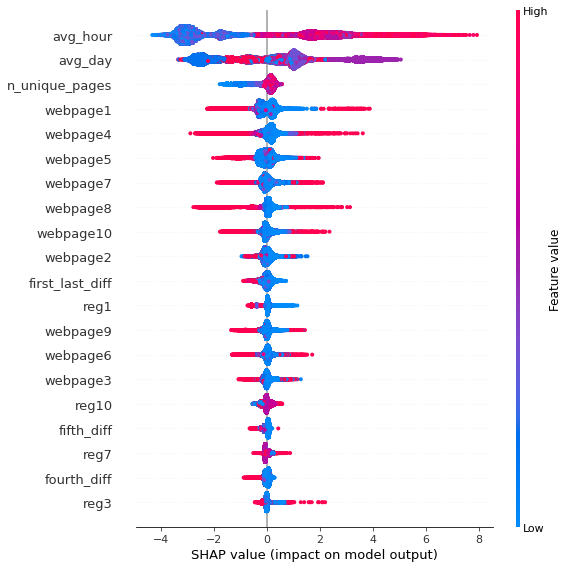

In [ ]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(test)
shap.summary_plot(shap_values, test)

Как мы видим, категориальные фичи оказались очень важны. Но наиболее "сильными" являются фичи "avg_hour" и "avg_day".

Перед тем, как начнем работать с двумя оставшимися методами, уберем из них категориальные фичи.

In [ ]:
train1 = train.drop(columns = ['webpage1', 'webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6', 'webpage7', 'webpage8', 'webpage9', 'webpage10'])
test1 = test.drop(columns = ['webpage1', 'webpage2', 'webpage3', 'webpage4', 'webpage5', 'webpage6', 'webpage7', 'webpage8', 'webpage9', 'webpage10'])

### LGMB

**Hyperparameters tunning**

Приведенные ниже параметры были подобраны ранее с помощью hyperopt. Приведу результат, иначе слишком долго все прогонять

In [ ]:
best_params = {'random_state':42,'boosting_type': 'gbdt', 'colsample_bytree': 1, 'lambda_l1': 0, 'lambda_l2': 0, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 35,
 'min_child_weight': 0.001, 'min_split_gain': 0.0613, 'n_estimators': 200, 'num_leaves': 88, 'subsample_for_bin': 200000}

**Model**

In [ ]:
lgb_clf = lgb.LGBMClassifier(**best_params)
lgb_model = lgb_clf.fit(train1, target) 
lgb_pred = lgb_model.predict_proba(test1)

In [ ]:
skf = StratifiedKFold(n_splits=5)
np.mean(cross_val_score(lgb_model, train1, target, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc'))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.7s finished


0.9610203069983418

Обратим внимание, что результат CatBoost выше. 

### XGBoost

**Model**

In [ ]:
xgb_clf = xgb.XGBClassifier()
xgb_model = xgb_clf.fit(train1, target) 
xgb_pred = xgb_model.predict_proba(test1)

In [ ]:
skf = StratifiedKFold(n_splits=5)
np.mean(cross_val_score(xgb_model, train1, target, cv=skf, n_jobs=-1, verbose=1, scoring='roc_auc'))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.5s finished


0.9447099010644378

Слишком низкий score. Этот метод мы использовать не будем.

Оценим значимость фичей

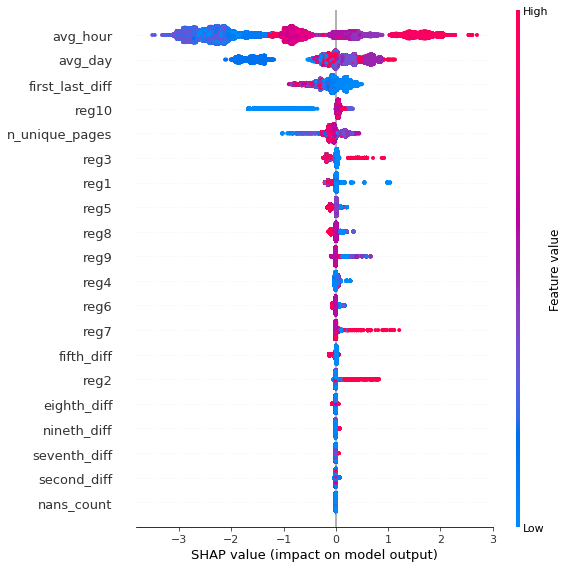

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(test1)
shap.summary_plot(shap_values, test1)

Все так же ключевыми являются две первые фичи.

### Saving submission

In [ ]:
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('notebook_submission5.csv')

In [ ]:
# Используем голосование
save_submission((cat_pred[:,1] + lgb_pred[:,1])/2)

# Еще вариант - работать как с тестом:

В начале работы с задачей мне показалась интересной идея посмотреть на поседовательность индексов как на последовательность слов. То есть попробовать поработать с ними методами анализа текстов.

К сожалению, данный подход не оправдал себя: кроссвалидация давала низкие значения. А при сабмите - 0.64

## Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score, f1_score

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier

from google_drive_downloader import GoogleDriveDownloader as gdd

## Download

In [ ]:
gdd.download_file_from_google_drive(file_id='1ZECXtMAYo6fR8HY4eCKw9rLYzcKsgGC2',\
                                    dest_path='/data/train.csv')
train = pd.read_csv('/data/train.csv', sep=',')

## Функция preprocessing

In [ ]:
def prepro (df):

      webpages = [n for n in df.columns if df[n].dtype == 'float64']
      webpages.append('webpage1')

      # Все Nan заменим на -1
      df.fillna(-1, inplace=True)

      # Переведем содержимое всех вебстраниц из float 64 в string
      for i in df.columns:

            if i in webpages:
                  transformation = lambda x: str(int(x))
                  df[i] = list(map(transformation, df[i]))

       # Сделаем фичу, где все эти названия будут в одной строчке. Чтобы в дальнейшем работать с этим как со строчкой
      df['List'] = ''

      for i in webpages:
              df['List'] = df['List'] + ' '+ df[i]

        # Много -1, который обозначают отсутствующие данные. Удалим их
      df.List = [x.replace('-1','') for x in df.List]
      df.List = [x.split() for x in df.List]
      df.List = [' '.join(x) for x in df.List]

      return df.List

## Tf

In [ ]:
y = train.target

In [ ]:
train = prepro (train)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                  decode_error = 'replace', 
                                  ngram_range = (1, 2),
                                  min_df = 3, 
                                  use_idf=True)

In [ ]:
transformed_texts = tfidf_vectorizer.fit_transform(train)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
  

Отберем лучшие 10 тысяч. На больше количестве вылетает ОЗУ.

In [ ]:
# Feature best selection

selection = SelectKBest(f_classif, 
                          k=min(10000, 
                          transformed_texts.shape[1]))
selection.fit(transformed_texts, y)
transformed_texts = selection.transform(transformed_texts).astype('float32') 
feature_names = feature_names[selection.get_support()]

In [ ]:
train = transformed_texts

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.toarray(), (np.array(y)), test_size=0.2, random_state=42)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))

## GaussianNB

In [ ]:
%%time
gnb = GaussianNB()
gnb_clf = gnb.fit(X_train,y_train)
gnb_predict = gnb.predict(X_test)
print(gnb_predict)

[1 0 0 ... 1 0 0]
CPU times: user 12.8 s, sys: 1.28 s, total: 14.1 s
Wall time: 14.1 s


In [ ]:
gnb_score = roc_auc_score(y_test, gnb_predict)
print("gnb score :", gnb_score)

gnb score : 0.7597942716006176


Очевидно, что это не очень продуктивный путь

## Test

In [ ]:
gdd.download_file_from_google_drive(file_id='12vPIGNYEO3y6UrtwoW8hVjY3z5uxV709',\
                                    dest_path='/data/test.csv')
test = pd.read_csv('/data/test.csv', sep=',')

In [ ]:
test = prepro(test)

In [ ]:
test = test.toarray()

In [ ]:
gnb_predict = gnb.predict(test)

In [ ]:
def save_submission(pred):
    pd.Series(
        pred, name='target', index=pd.Index(range(len(pred)), name='session_id')
    ).to_csv('notebook_submission_gnb.csv')

In [ ]:
save_submission(gnb_predict)